In [1]:
# Load the Julia environment needed for this notebook
import Pkg
Pkg.activate("../Tasks2D")


  Activating project at `~/Developer/research/fall2023/cocosci/tasks2D/Tasks2D`


In [2]:
import LinearAlgebra
import Makie   # Visualization Library
using Revise      # For development; makes it so modifications
                  # to imported modules are immediately reflected in this Julia session
using Gen         # Gen probabilistic programming library
import GenParticleFilters # Additional particle filtering functionality for Gen
import GridWorlds # Simple gridworld functionality
import LineWorlds
const L = LineWorlds
import LineWorlds: cast # Ray caster
import GenPOMDPs  # Beginnings of a Gen POMDP library

import Tasks2D

includet("SLAM/Utils.jl")

In [3]:
import GLMakie
GLMakie.activate!()

In [4]:
# Initial position model

# Distribution to sample uniformly from a Julia Set
using Tasks2D.Distributions: uniform_from_set

@gen (static) function uniform_agent_pos(t_to_params)
    w = t_to_params(0).map # a map, represented as a GridWorlds.GridWorld
    
    cell ~ uniform_from_set(GridWorlds.empty_cells(w))
    
    # Cell (i, j) corresponds to the region from i-1 to i and j-1 to j
    x ~ uniform(cell[1] - 1, cell[1])
    y ~ uniform(cell[2] - 1, cell[2])
    
    return ([x, y], 0, false)
end

function det_next_pos(pos, a, Δ)
    (x, y) = pos
    a == :up    ? [x, y + Δ] :
    a == :down  ? [x, y - Δ] : 
    a == :left  ? [x - Δ, y] :
    a == :right ? [x + Δ, y] :
    a == :stay  ? [x, y]     :
                error("Unrecognized action: $a")
end

function handle_wall_intersection(prev, new, gridworld)
    walls = GridWorlds.nonempty_segments(gridworld)
    move = L.Segment(prev, new)
    
    min_collision_dist = Inf
    vec_to_min_dist_collision = nothing
    for i in 1:(size(walls)[1])
        wall = walls[i, :]
        # print("wall: $wall")
        do_intersect, dist = L.Geometry.cast(move, L.Segment(wall))

        if do_intersect && dist ≤ L.Geometry.norm(move)
            if dist < min_collision_dist
                min_collision_dist = dist
                vec_to_min_dist_collision = L.Geometry.diff(move)
            end
        end
    end
    
    if !isnothing(vec_to_min_dist_collision)
        dist = min_collision_dist
        if dist < 0.05
            return (prev, true)
        else
            normalized_vec = (vec_to_min_dist_collision / L.Geometry.norm(vec_to_min_dist_collision))
            collision_pt = prev + (dist - 0.04) * normalized_vec
            return (collision_pt, true)
        end
    end
    
    return (new, false)
end

@gen (static) function motion_model(state, action, t_to_params)
    (a, wall_clock_time) = action
    (pos, t_prev, prev_hit_wall) = state
    params = t_to_params(t_prev + 1)
    w, σ = params.map, params.step.σ
    
    next_pos_det = det_next_pos(pos, a, params.step.Δ)
    noisy_next_pos ~ broadcasted_normal(next_pos_det, params.step.σ)
    (next_pos, hit_wall) = handle_wall_intersection(pos, noisy_next_pos, w)
    
    return (next_pos, t_prev + 1, prev_hit_wall || hit_wall)
end

@gen function observe_noisy_distances(state, t_to_params)
    (pos, t, _) = state
    params = t_to_params(t)

    p = reshape([pos..., params.obs.orientation], (1, 3))
    _as = L.create_angles(params.obs.fov, params.obs.n_rays)
    wall_segs = GridWorlds.wall_segments(params.map)
    strange_segs = GridWorlds.strange_segments(params.map)
    
    w, s_noise, outlier, outlier_vol, zmax = params.obs.wall_sensor_args
    dists_walls = L.cast(p, wall_segs; num_a=params.obs.n_rays, zmax)
    dists_walls = reshape(dists_walls, (:,))

    w, s_noise, outlier, outlier_vol, zmax = params.obs.strange_sensor_args
    dists_strange = L.cast(p, strange_segs; num_a=params.obs.n_rays, zmax)
    dists_strange = reshape(dists_strange, (:,))

    is_wall_measurement = [w < s for (w, s) in zip(dists_walls, dists_strange)]
    wall_measurements = dists_walls[is_wall_measurement]
    
    σ_wall = params.obs.wall_sensor_args.σ
    noisy_wall_measurements ~ Gen.broadcasted_normal(wall_measurements, s_noise)

    strange_measurements = dists_strange[[!w for w in is_wall_measurement]]
    if !isempty(strange_measurements)
        mins = [params.obs.strange_sensor_args.dist_to_zmin(m) for m in strange_measurements]
        maxs = [params.obs.strange_sensor_args.dist_to_zmax(m) for m in strange_measurements]
        noisy_strange_measurements ~ Utils.mapped_uniform(mins, maxs)
    else
        noisy_strange_measurements = []
    end

    obs = []
    wall_ctr = 1
    strange_ctr = 1
    for i in 1:params.obs.n_rays
        if is_wall_measurement[i]
            push!(obs, noisy_wall_measurements[wall_ctr])
            wall_ctr += 1
        else
            push!(obs, noisy_strange_measurements[strange_ctr])
            strange_ctr += 1
        end
    end
    # dists = min.(dists_walls, dists_strange)
    # dists = reshape(dists, (:,))

    # # get vector of sigmas, to apply to `dists`
    # # params.obs.sensor_args.σ_wall for walls; params.obs.sensor_args.σ_strange for strange
    # # σ_strange = params.obs.strange_sensor_args.σ
    # sigmas = [w < s ? σ_wall : σ_strange for (w, s) in zip(dists_walls, dists_strange)]
    # sigmas = reshape(sigmas, (:,))

    # obs ~ Gen.mvnormal(dists, LinearAlgebra.Diagonal(sigmas))
    return obs
end

# POMDP of this environment
pomdp = GenPOMDPs.GenPOMDP(
    uniform_agent_pos,       # INIT   : params                      ⇝ state
    motion_model,            # STEP   : prev_state, actions, params ⇝ state
    observe_noisy_distances, # OBS    : state, params               ⇝ observation
    (state, action) -> 0.    # UTILITY: state, action, params       → utility
)

# Generative function over trajectories of the POMDP,
# given a fixed action sequence.
trajectory_model = GenPOMDPs.ControlledTrajectoryModel(pomdp)

GenPOMDPs.var"##StaticGenFunction__ControlledTrajectoryModel#435"(Dict{Symbol, Any}(), Dict{Symbol, Any}())

In [5]:
function get_posobs_seq(groundtruth_trace)
    return map(
        trace -> (
            [p for (p, t, h) in GenPOMDPs.state_sequence(trace)],
            [reshape(o, (:,)) for o in GenPOMDPs.observation_retval_sequence(trace)]
        ),
        groundtruth_trace
    )
end
function get_obs_seq(groundtruth_trace)
    return map(
        trace -> [reshape(o, (:,)) for o in GenPOMDPs.observation_retval_sequence(trace)],
        groundtruth_trace
    )
end

using Dates

function get_save_tr(tr)
    function save_tr(viz_actions)
        filename = "saves/" * string(now()) * "__pomdp_trace.jld"
        Utils.serialize_trace_and_viz_actions(filename, tr[];
            viz_actions=viz_actions,
            # args_to_serializeable = args -> (args[1:2]..., args[3].params)
        )
    end
    return save_tr
end

function get_take_action(_take_action)
    function take_action(a)
        _take_action((a, Dates.now()))
    end
    return take_action
end
function get_interactive_trace(args...; kwargs...)
    (trace, _take_action) = GenPOMDPs.interactive_world_trace(args...; kwargs...)
    return (trace, get_take_action(_take_action))
end
function make_trace_interactive(args...; kwargs...)
    (trace, _take_action) = GenPOMDPs.make_trace_interactive(args...; kwargs...)
    return (trace, get_take_action(_take_action))
end

function get_did_hitwall_observable(trace)
    return map(trace -> GenPOMDPs.state_sequence(trace)[end][3], trace)
end
function close_window(f)
    glfw_window = GLMakie.to_native(display(f))
    GLMakie.GLFW.SetWindowShouldClose(glfw_window, true)
end

function get_action_times_observable(trace)
    return map(trace -> [t for (a, t) in GenPOMDPs.action_sequence(trace)], trace)
end
function get_timing_args(trace; speedup_factor=1, max_delay=5) # 5 seconds max delay
    return (get_action_times_observable(trace), speedup_factor, max_delay)
end

struct ConstantTToParams
    params
end
(p::ConstantTToParams)(t) = p.params

struct SwitchTToParams
    params1
    params2
    switch
end
(p::SwitchTToParams)(t::Makie.Observable) = p(t[])
(p::SwitchTToParams)(t) = p.switch(t) ? p.params1 : p.params2

struct TimedSwitchTToParams
    params1
    params2
    timewindows_params1
    timewindows_params2
end
(p::TimedSwitchTToParams)(t::Makie.Observable) = p(t[])
function (p::TimedSwitchTToParams)(t)
    for (start, stop) in p.timewindows_params1
        if start ≤ t ≤ stop
            return p.params1
        end
    end
    for (start, stop) in p.timewindows_params2
        if start ≤ t ≤ stop
            return p.params2
        end
    end
    error("No time window found for time $t")
end

struct DistanceToConstant
    c
end
(d::DistanceToConstant)(x) = d.c
struct MultiplyDistanceByConstant
    c
end
(d::MultiplyDistanceByConstant)(x) = 2. + x * d.c

In [6]:
readdir("saves")

319-element Vector{String}:
 "2023-12-06T15:21:41.953__pomdp_trace.jld"
 "2023-12-12T14:01:29.780__pomdp_trace.jld"
 "2023-12-12T14:01:39.916__pomdp_trace.jld"
 "2023-12-12T14:04:01.037__pomdp_trace.jld"
 "2023-12-12T14:07:17.605__pomdp_trace.jld"
 "2023-12-12T14:17:17.424__pomdp_trace.jld"
 "2023-12-12T14:32:17.755__pomdp_trace.jld"
 "2023-12-12T14:36:09.460__pomdp_trace.jld"
 "2023-12-12T15:27:52.313__pomdp_trace.jld"
 "2023-12-12T15:50:16.517__pomdp_trace.jld"
 "2023-12-12T15:51:18.757__pomdp_trace.jld"
 "2023-12-12T16:03:19.086__pomdp_trace.jld"
 "2023-12-12T16:10:20.411__pomdp_trace.jld"
 ⋮
 "2023-12-14T13:20:14.907__pomdp_trace.jld"
 "2023-12-14T13:21:36.934__pomdp_trace.jld"
 "2023-12-14T13:24:49.136__pomdp_trace.jld"
 "2023-12-14T13:27:48.268__pomdp_trace.jld"
 "2023-12-14T13:28:29.281__pomdp_trace.jld"
 "2023-12-14T13:29:24.615__pomdp_trace.jld"
 "2023-12-14T13:29:30.131__pomdp_trace.jld"
 "2023-12-14T13:30:13.391__pomdp_trace.jld"
 "2023-12-14T13:30:15.630__pomdp_trace.jld"
 

In [13]:
# Unique identifier substring of the first save for each participant.
firsts = sort([
    "13T18:04:45", # lio
    "13T18:37:32", # mirko
    # "14T10:44:03", # Me playing around.  TODO - delete 14T10:44:03 to 14T10:52:44
    "14T11:58", # matin
    "14T12:16", # adam
    "14T12:52", # nick
    "14T13:07", # eddie
    "14T13:19", # julia
])

7-element Vector{String}:
 "13T18:04:45"
 "13T18:37:32"
 "14T11:58"
 "14T12:16"
 "14T12:52"
 "14T13:07"
 "14T13:19"

In [14]:
file_sets = []
participant_idx = 0
for filename in readdir("saves")
    !contains(filename, "pomdp_trace.jld") && continue
    if participant_idx < length(firsts) && contains(filename, firsts[participant_idx + 1])
        push!(file_sets, [filename])
        participant_idx += 1
    elseif participant_idx > 0
        push!(file_sets[end], filename)
    end
end

In [17]:
import Random
file_sets = Random.shuffle(file_sets)

7-element Vector{Any}:
 ["2023-12-13T18:37:32.078__pomdp_trace.jld", "2023-12-13T18:37:32.094__pomdp_trace.jld", "2023-12-13T18:37:32.130__pomdp_trace.jld", "2023-12-13T18:37:32.166__pomdp_trace.jld", "2023-12-13T18:37:32.205__pomdp_trace.jld", "2023-12-13T18:37:32.250__pomdp_trace.jld", "2023-12-13T18:37:32.286__pomdp_trace.jld", "2023-12-13T18:40:08.657__pomdp_trace.jld", "2023-12-13T18:40:47.556__pomdp_trace.jld", "2023-12-13T18:42:02.441__pomdp_trace.jld", "2023-12-13T18:42:37.832__pomdp_trace.jld"]
 ["2023-12-14T13:19:36.681__pomdp_trace.jld", "2023-12-14T13:19:41.373__pomdp_trace.jld", "2023-12-14T13:19:44.631__pomdp_trace.jld", "2023-12-14T13:19:50.727__pomdp_trace.jld", "2023-12-14T13:19:56.443__pomdp_trace.jld", "2023-12-14T13:19:58.685__pomdp_trace.jld", "2023-12-14T13:20:02.236__pomdp_trace.jld", "2023-12-14T13:20:14.592__pomdp_trace.jld", "2023-12-14T13:20:14.634__pomdp_trace.jld", "2023-12-14T13:20:14.674__pomdp_trace.jld"  …  "2023-12-14T13:21:36.934__pomdp_trace.jld", "2

In [18]:
function deduplicate_participant_traces(traces)
    isempty(traces) && return traces
    deduplicated = [traces[1]]
    for tr in traces[2:end]
        prev_tr = deduplicated[end]

        actions1 = GenPOMDPs.action_sequence(prev_tr)
        actions2 = GenPOMDPs.action_sequence(tr)
        is_prefix = true
        for (a1, a2) in zip(actions1, actions2)
            if a1 != a2
                is_prefix = false
                break
            end
        end
        if !is_prefix
            push!(deduplicated, tr)
        end
    end
    return deduplicated
end

deduplicate_participant_traces (generic function with 1 method)

In [19]:
function load_tr(filename)
    tr, _ = Utils.deserialize_trace_and_viz_actions(
        filename,
        trajectory_model,
    );
    return tr
end
load_file_and_visualize(filename) = visualize_trace(load_tr(filename))
function visualize_trace(tr)
    trace, take_action = make_trace_interactive(tr);

    (f, t, _replay_actions) = GridWorlds.Viz.interactive_gui(
        t -> get_args(trace[])[3](t).map, get_posobs_seq(trace), take_action,
        save_fn=get_save_tr(trace),
        framerate=8,

        # Timing control for playback
        timing_args=get_timing_args(trace; speedup_factor=6, max_delay=1)
    )
    display(f)
end

visualize_trace (generic function with 1 method)

In [20]:
traces = []
for fileset in file_sets
    traces_for_participant = []
    for filename in fileset
        push!(traces_for_participant, load_tr("saves/" * filename))
    end
    traces_for_participant = deduplicate_participant_traces(traces_for_participant)
    push!(traces, traces_for_participant)
end

In [21]:
map(length, traces)

7-element Vector{Int64}:
  5
  6
 13
  8
  1
  5
  7

In [14]:
i = 0

0

In [15]:
i += 1
visualize_trace(vcat(traces...)[i])
i

1

In [16]:
visualize_trace(traces[4][3])

Trace & viz actions serialized to saves/2023-12-14T12:19:47.937__pomdp_trace.jld.


GLMakie.Screen(...)

In [120]:
MAP_INTRO = GridWorlds.load_houseexpo_gridworld(24, 1)
MAP_EXPLAIN_STRANGE = GridWorlds.load_custom_map(3)
MAP_W_STRANGE = GridWorlds.load_custom_map(4)
MAP_WOUT_STRANGE = GridWorlds.load_custom_map(5)
MAP2_W_STRANGE = GridWorlds.load_custom_map(6)
MAP2_WOUT_STRANGE = GridWorlds.load_custom_map(7);

In [23]:
# (i, trace) pairs where i is participant index
intro_traces = []
learnmap_traces = []
test1_traces = []
learnstrange_traces = []
test2_traces = []

named_trace_lists = Dict(
    "intro" => intro_traces,
    "learnmap" => learnmap_traces,
    "test1" => test1_traces,
    "learnstrange" => learnstrange_traces,
    "test2" => test2_traces
)

for (i, participant_traces) in enumerate(traces)
    for (j, tr) in enumerate(participant_traces)
        T, actions, t_to_params = get_args(tr)
        mp = t_to_params(T)
        if mp.map == MAP_INTRO
            push!(intro_traces, (i, tr))
        elseif mp.map == MAP_EXPLAIN_STRANGE
            push!(learnstrange_traces, (i, tr))
        elseif mp.map == MAP_W_STRANGE
            push!(test1_traces, (i, tr))
        elseif mp.map == MAP_WOUT_STRANGE
            push!(learnmap_traces, (i, tr))
        elseif mp.map == MAP2_W_STRANGE
            push!(test2_traces, (i, tr))
        else
            print("Unrecognized map in traces[$i][$j]")
        end
    end
end

In [24]:
Dict(k => length(v) for (k, v) in pairs(named_trace_lists))

Dict{String, Int64} with 5 entries:
  "learnmap"     => 6
  "learnstrange" => 8
  "intro"        => 14
  "test2"        => 7
  "test1"        => 10

In [121]:
named_trace_lists["learnmap"];

In [47]:
# Plot 1 path
i = 4
tr = named_trace_lists["learnmap"][i][2]
t, _, t_to_params = get_args(tr)
params = t_to_params(t)

f = GridWorlds.Viz.plot_paths(
    params.map,
    [[p for (p, t, h) in GenPOMDPs.state_sequence(tr)]]
)
display(f)

GLMakie.Screen(...)

In [ ]:
# Plot 2 paths
i = 4
tr = named_trace_lists["learnmap"][i][2]
t, _, t_to_params = get_args(tr)
params = t_to_params(t)

f = GridWorlds.Viz.plot_paths(
    params.map,
    [[p for (p, t, h) in GenPOMDPs.state_sequence(named_trace_lists["learnmap"][i][2])] for i in 1:length(named_trace_lists["learnmap"])]
)
display(f)

In [49]:
size(params.map)

(37, 28)

In [34]:
map(Makie.Point2, [p for (p, t, h) in GenPOMDPs.state_sequence(tr)])

729-element Vector{GeometryBasics.Point2{Float64}}:
 [2.0909236522984638, 2.081130870747996]
 [2.090105321082122, 2.5922876697817654]
 [2.091307084228513, 3.0962240790760207]
 [2.098604224595157, 3.6020811382064317]
 [2.097878594000844, 4.101877391395979]
 [2.0924488074812673, 4.6166990575497255]
 [2.0953226439423815, 5.119859744039007]
 [2.094250922031584, 5.619178895819147]
 [2.0952721519803634, 6.1253826168652505]
 [2.1014781486792002, 6.6291296774680735]
 [2.113302161138774, 7.133496097705829]
 [2.1142876173864957, 7.624082813648838]
 [2.102952041205768, 8.121322231041837]
 ⋮
 [2.7062795802853103, 8.025574082131516]
 [2.705092979311728, 7.5322154198613935]
 [2.7063562813650446, 7.0314336669813065]
 [2.705896053411016, 6.524248491145045]
 [2.7051885593336786, 6.026851870948283]
 [2.710440441159331, 5.521076761970365]
 [2.7192318252409833, 5.027365419637074]
 [2.7220698359009488, 4.521255296307669]
 [2.722508452153472, 4.020937867548719]
 [2.7218705525466436, 3.5189893377517953]
 [2.

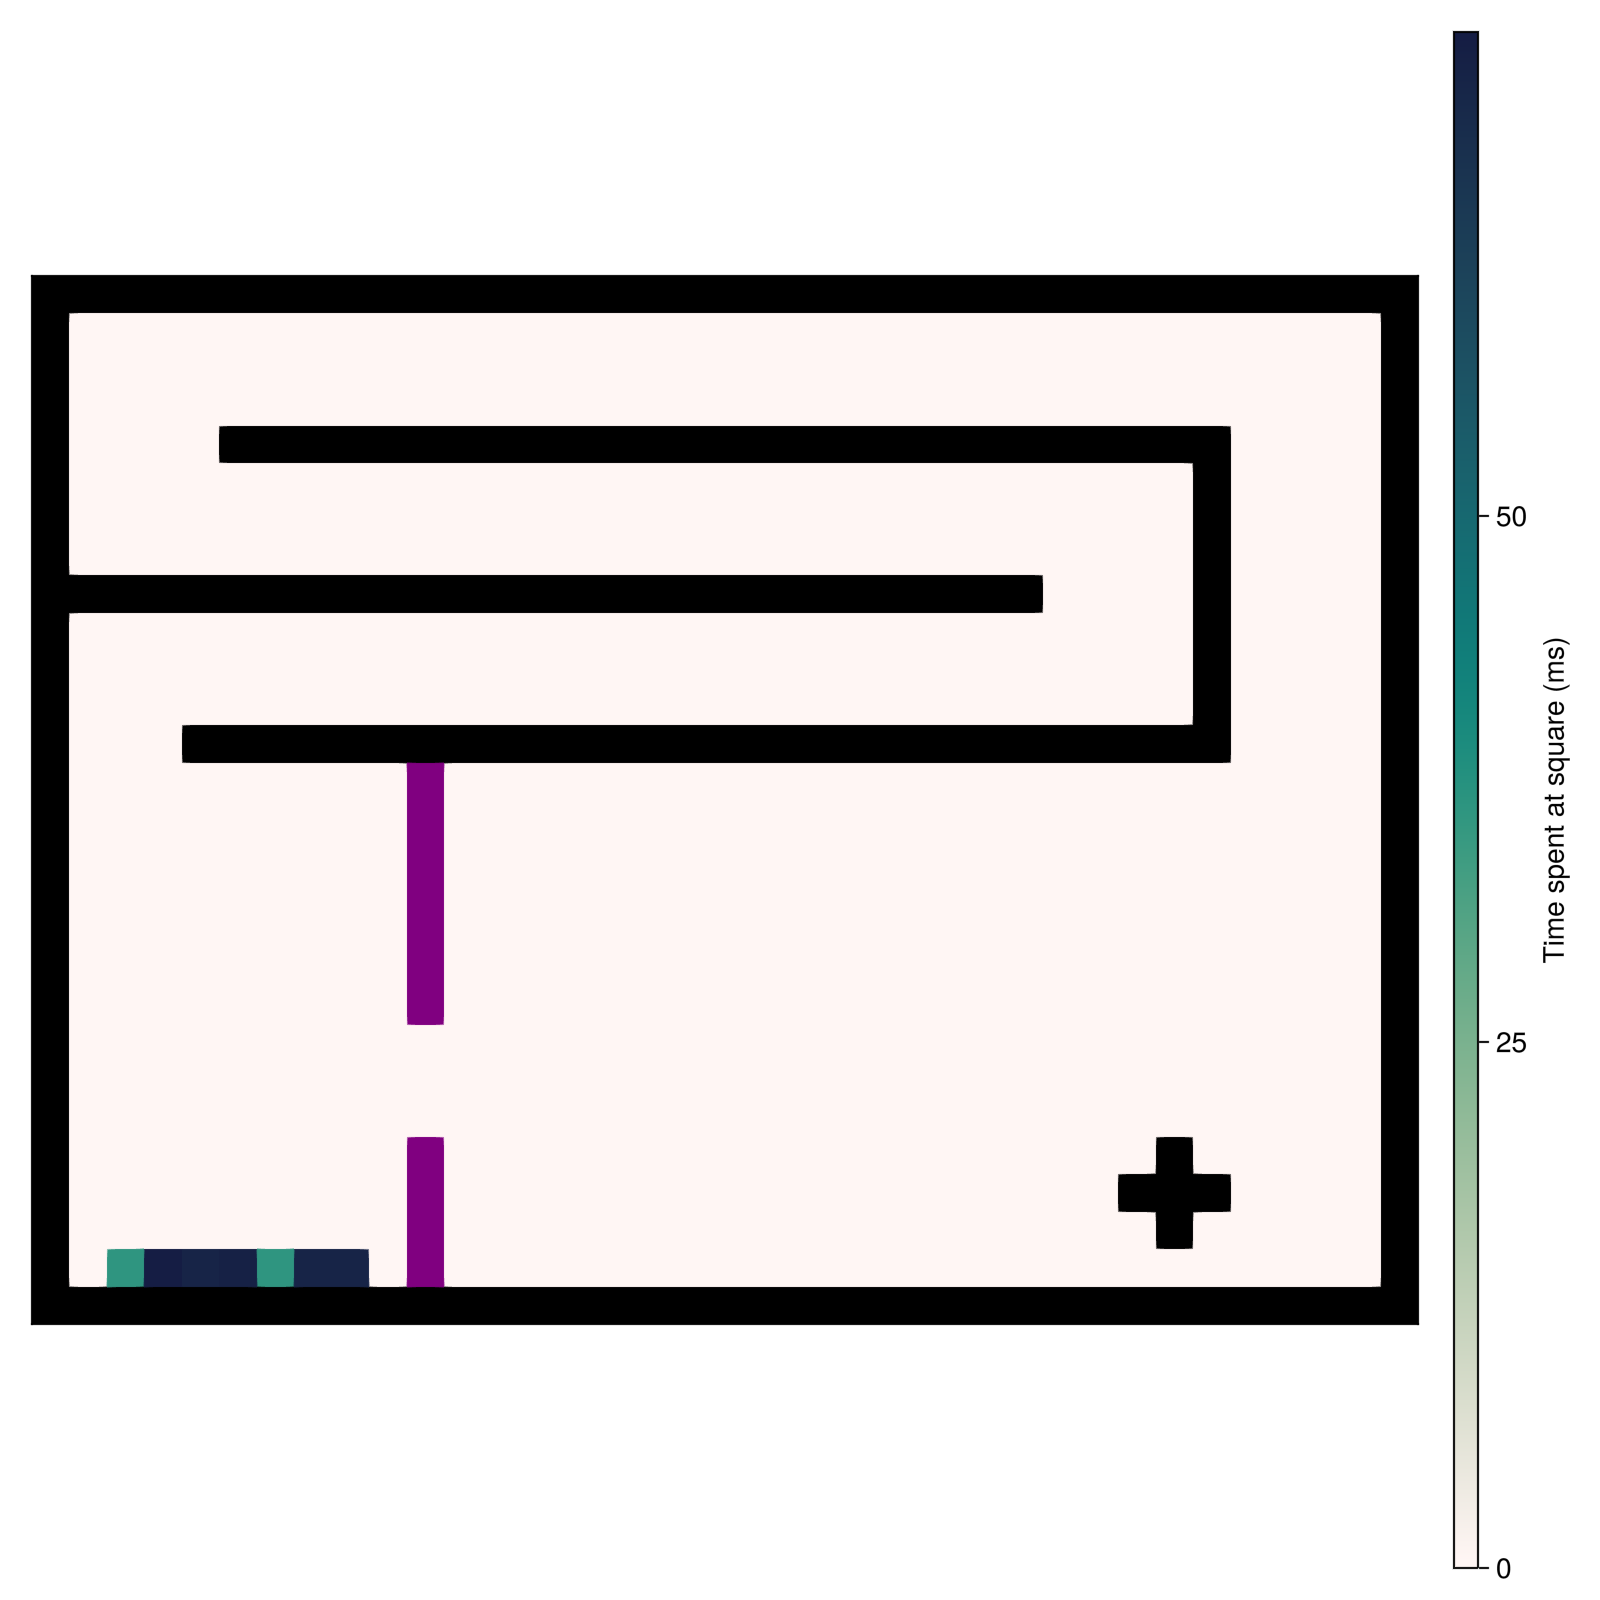

In [85]:
# 1-world heatmap
GridWorlds.Viz.time_heatmap(
    params.map,
    [[p for (p, t, h) in GenPOMDPs.state_sequence(tr)]],
    [[t for (a, t) in GenPOMDPs.action_sequence(tr)]],
)

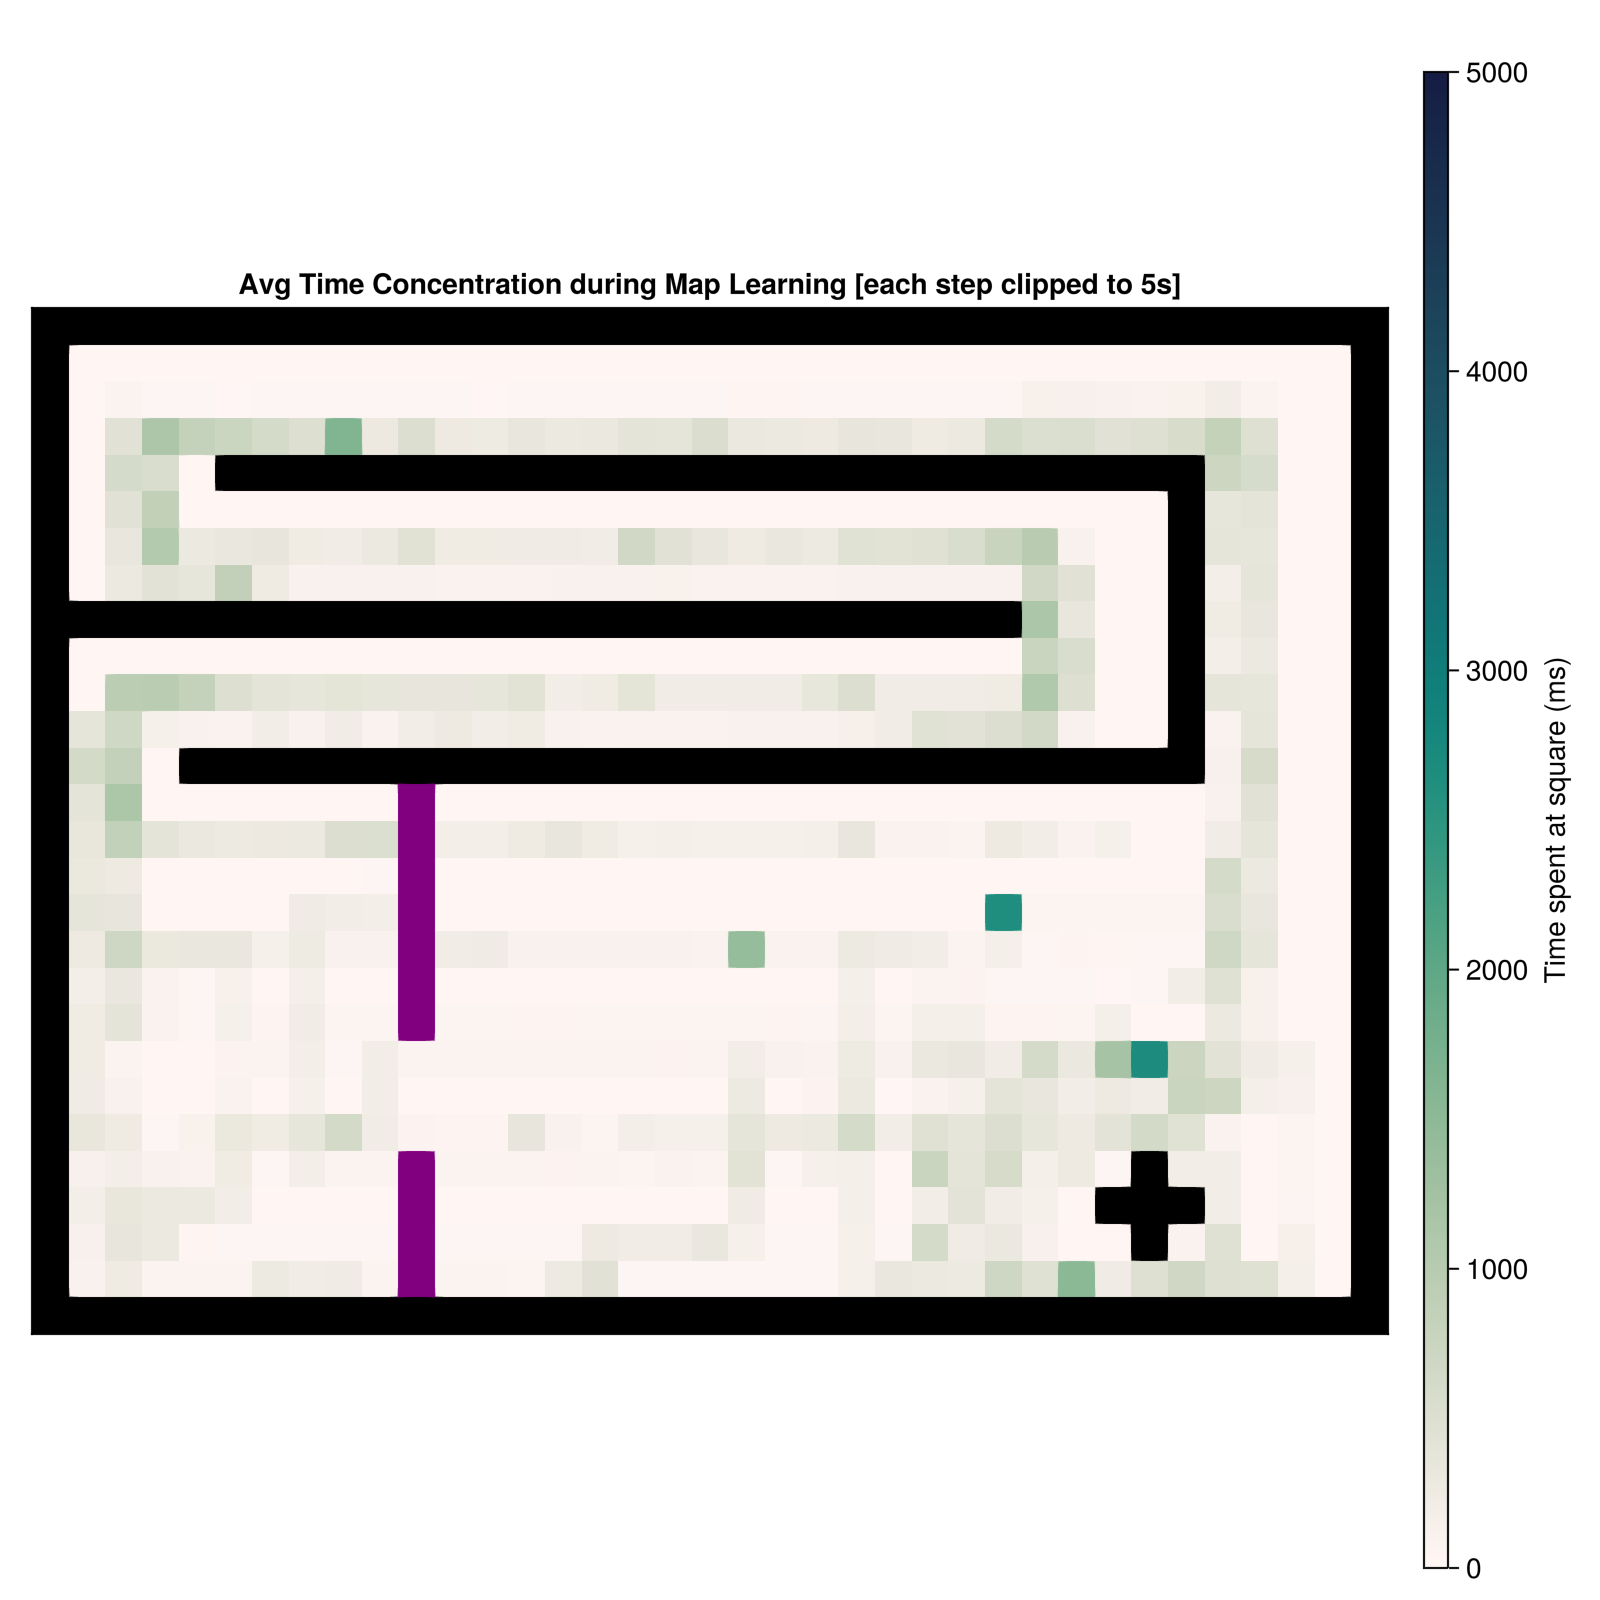

In [107]:
# multi-run heatmap
GridWorlds.Viz.time_heatmap(
    params.map,
    [[p for (p, t, h) in GenPOMDPs.state_sequence(tr)] for tr in map(x -> x[2], named_trace_lists["learnmap"])],
    [[t for (a, t) in GenPOMDPs.action_sequence(tr)] for tr in map(x -> x[2], named_trace_lists["learnmap"])],
    title="Avg Time Concentration during Map Learning [each step clipped to 5s]",
    do_avg=true,
    n_to_avg_over=length(Set(map(x -> x[1], named_trace_lists["learnmap"])))
)

^ maybe not surprising, people spend time checking out the cross, and the hallway

Now try in the first test:

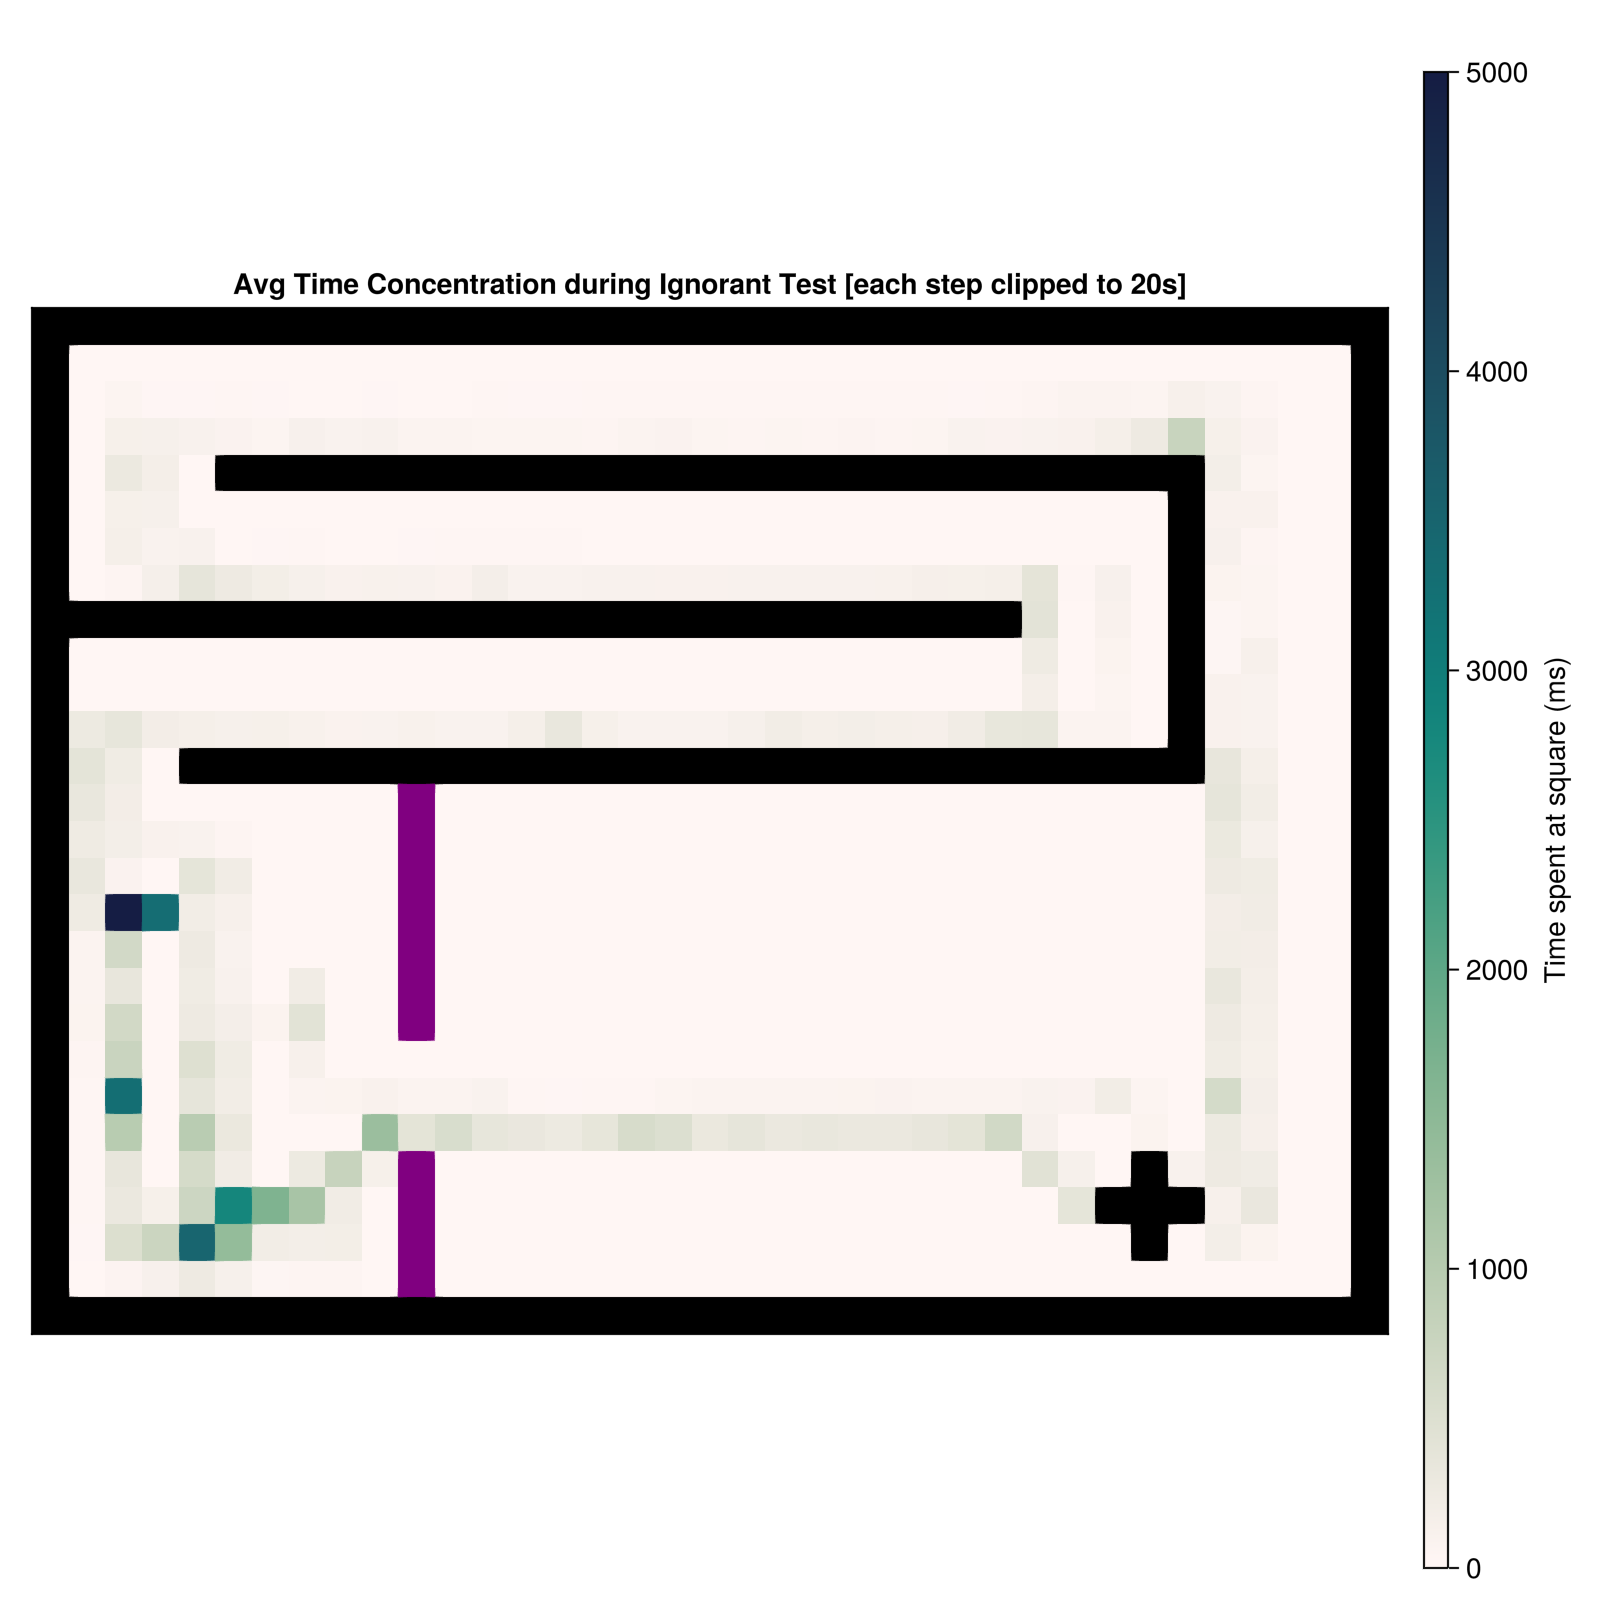

In [117]:
# multi-run heatmap

i = 4
tr = named_trace_lists["test1"][i][2]
t, _, t_to_params = get_args(tr)
params = t_to_params(t)

GridWorlds.Viz.time_heatmap(
    params.map,
    [[p for (p, t, h) in GenPOMDPs.state_sequence(tr)] for tr in map(x -> x[2], named_trace_lists["test1"])],
    [[t for (a, t) in GenPOMDPs.action_sequence(tr)] for tr in map(x -> x[2], named_trace_lists["test1"])],
    clip_ms=20_000,
    title="Avg Time Concentration during Ignorant Test [each step clipped to 20s]",
    do_avg=true,
    n_to_avg_over=length(Set(map(x -> x[1], named_trace_lists["test1"])))
)

^ times spent

v steps spent

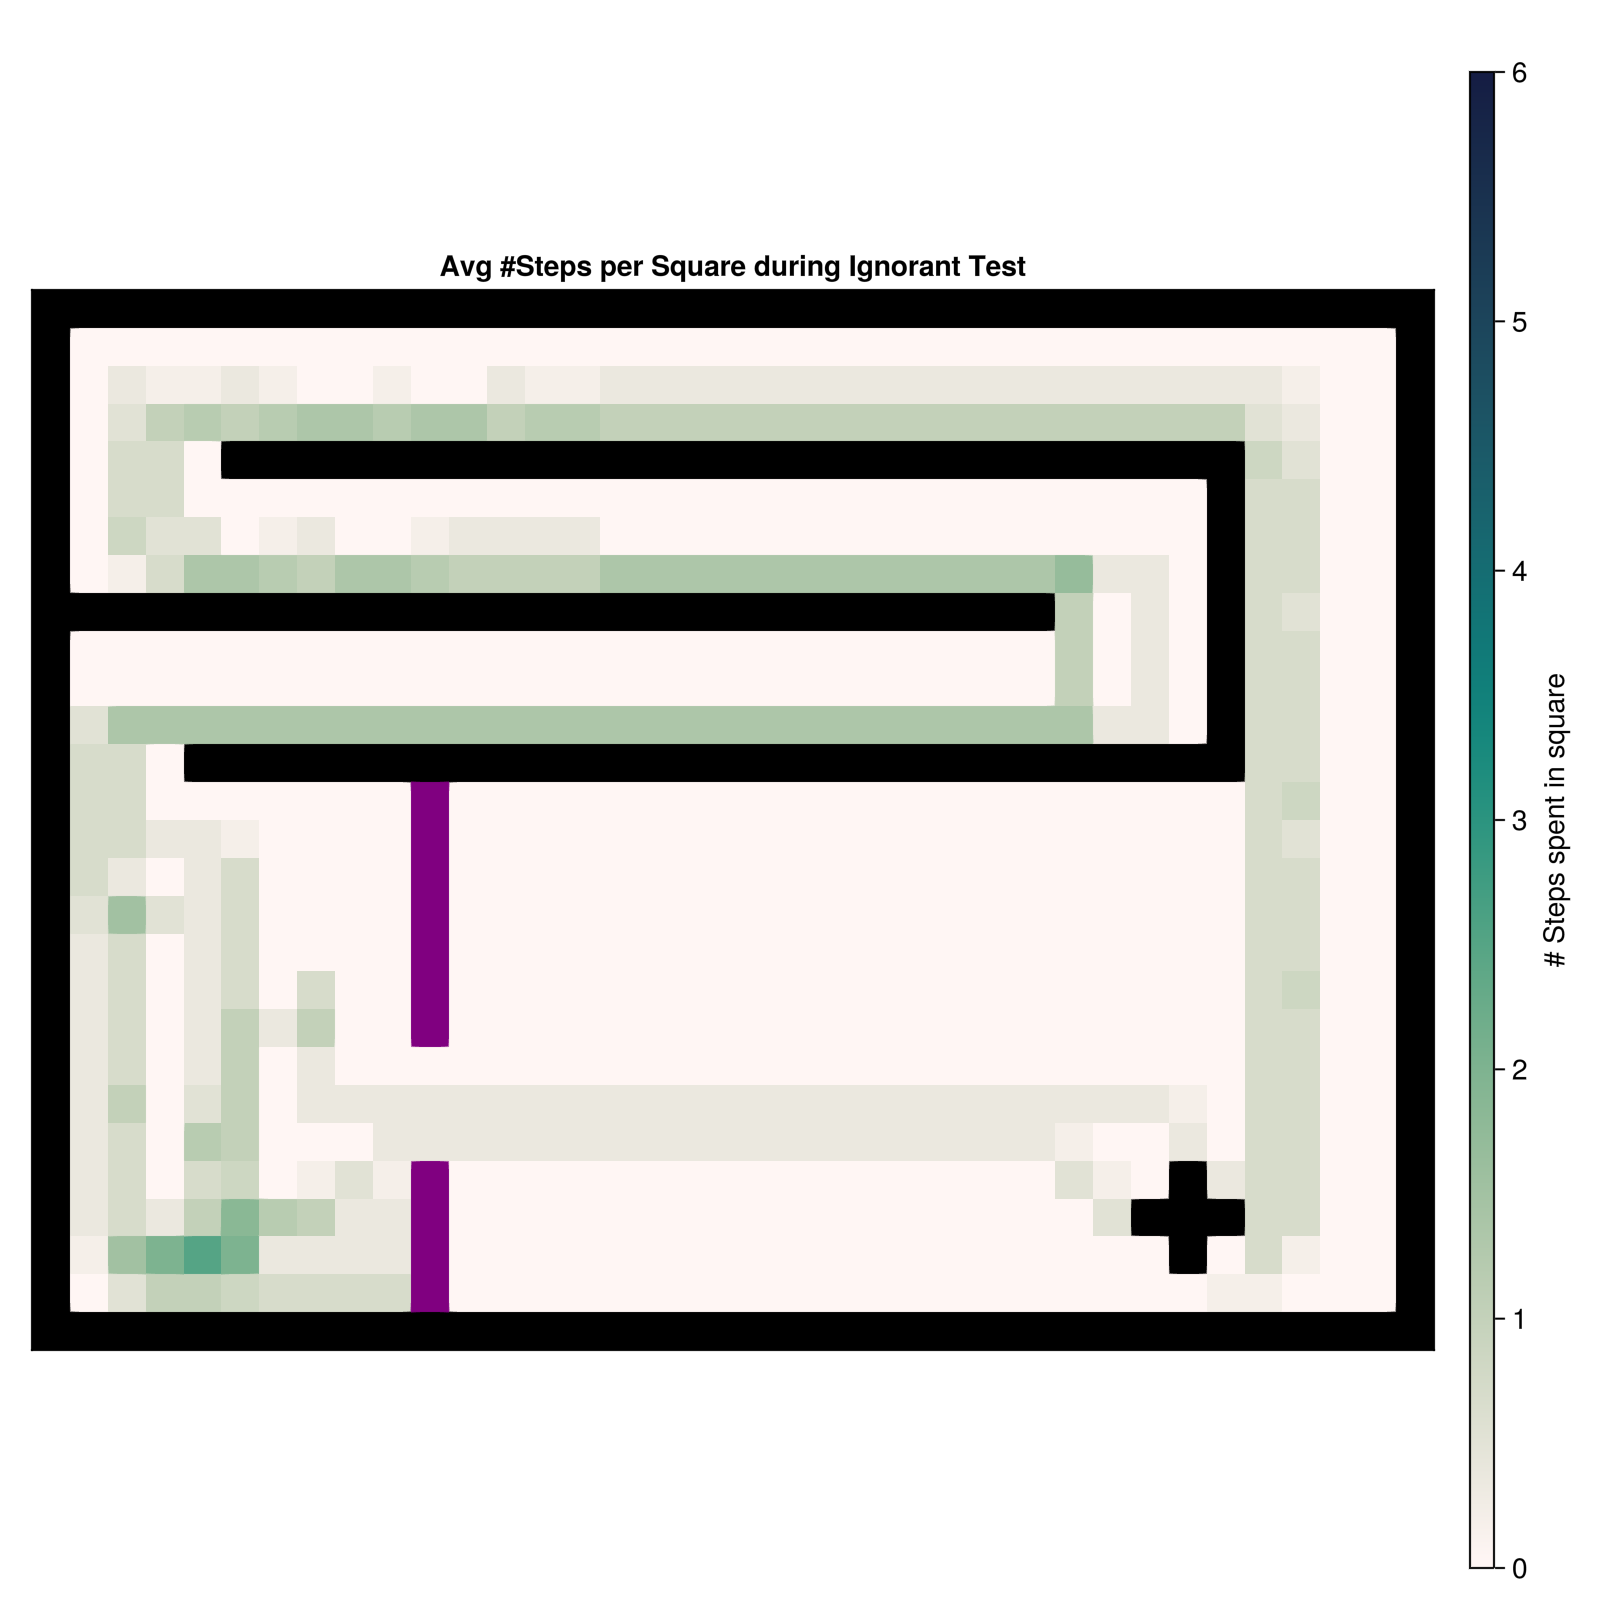

In [118]:
GridWorlds.Viz.time_heatmap(
    params.map,
    [[p for (p, t, h) in GenPOMDPs.state_sequence(tr)] for tr in map(x -> x[2], named_trace_lists["test1"])],
    [[t for (a, t) in GenPOMDPs.action_sequence(tr)] for tr in map(x -> x[2], named_trace_lists["test1"])],
    use_times=false,
    title="Avg #Steps per Square during Ignorant Test",
    do_avg=true,
    n_to_avg_over=length(Set(map(x -> x[1], named_trace_lists["test1"])))
)

(:data, :pixel, :relative, :clip)

now, look at final run times

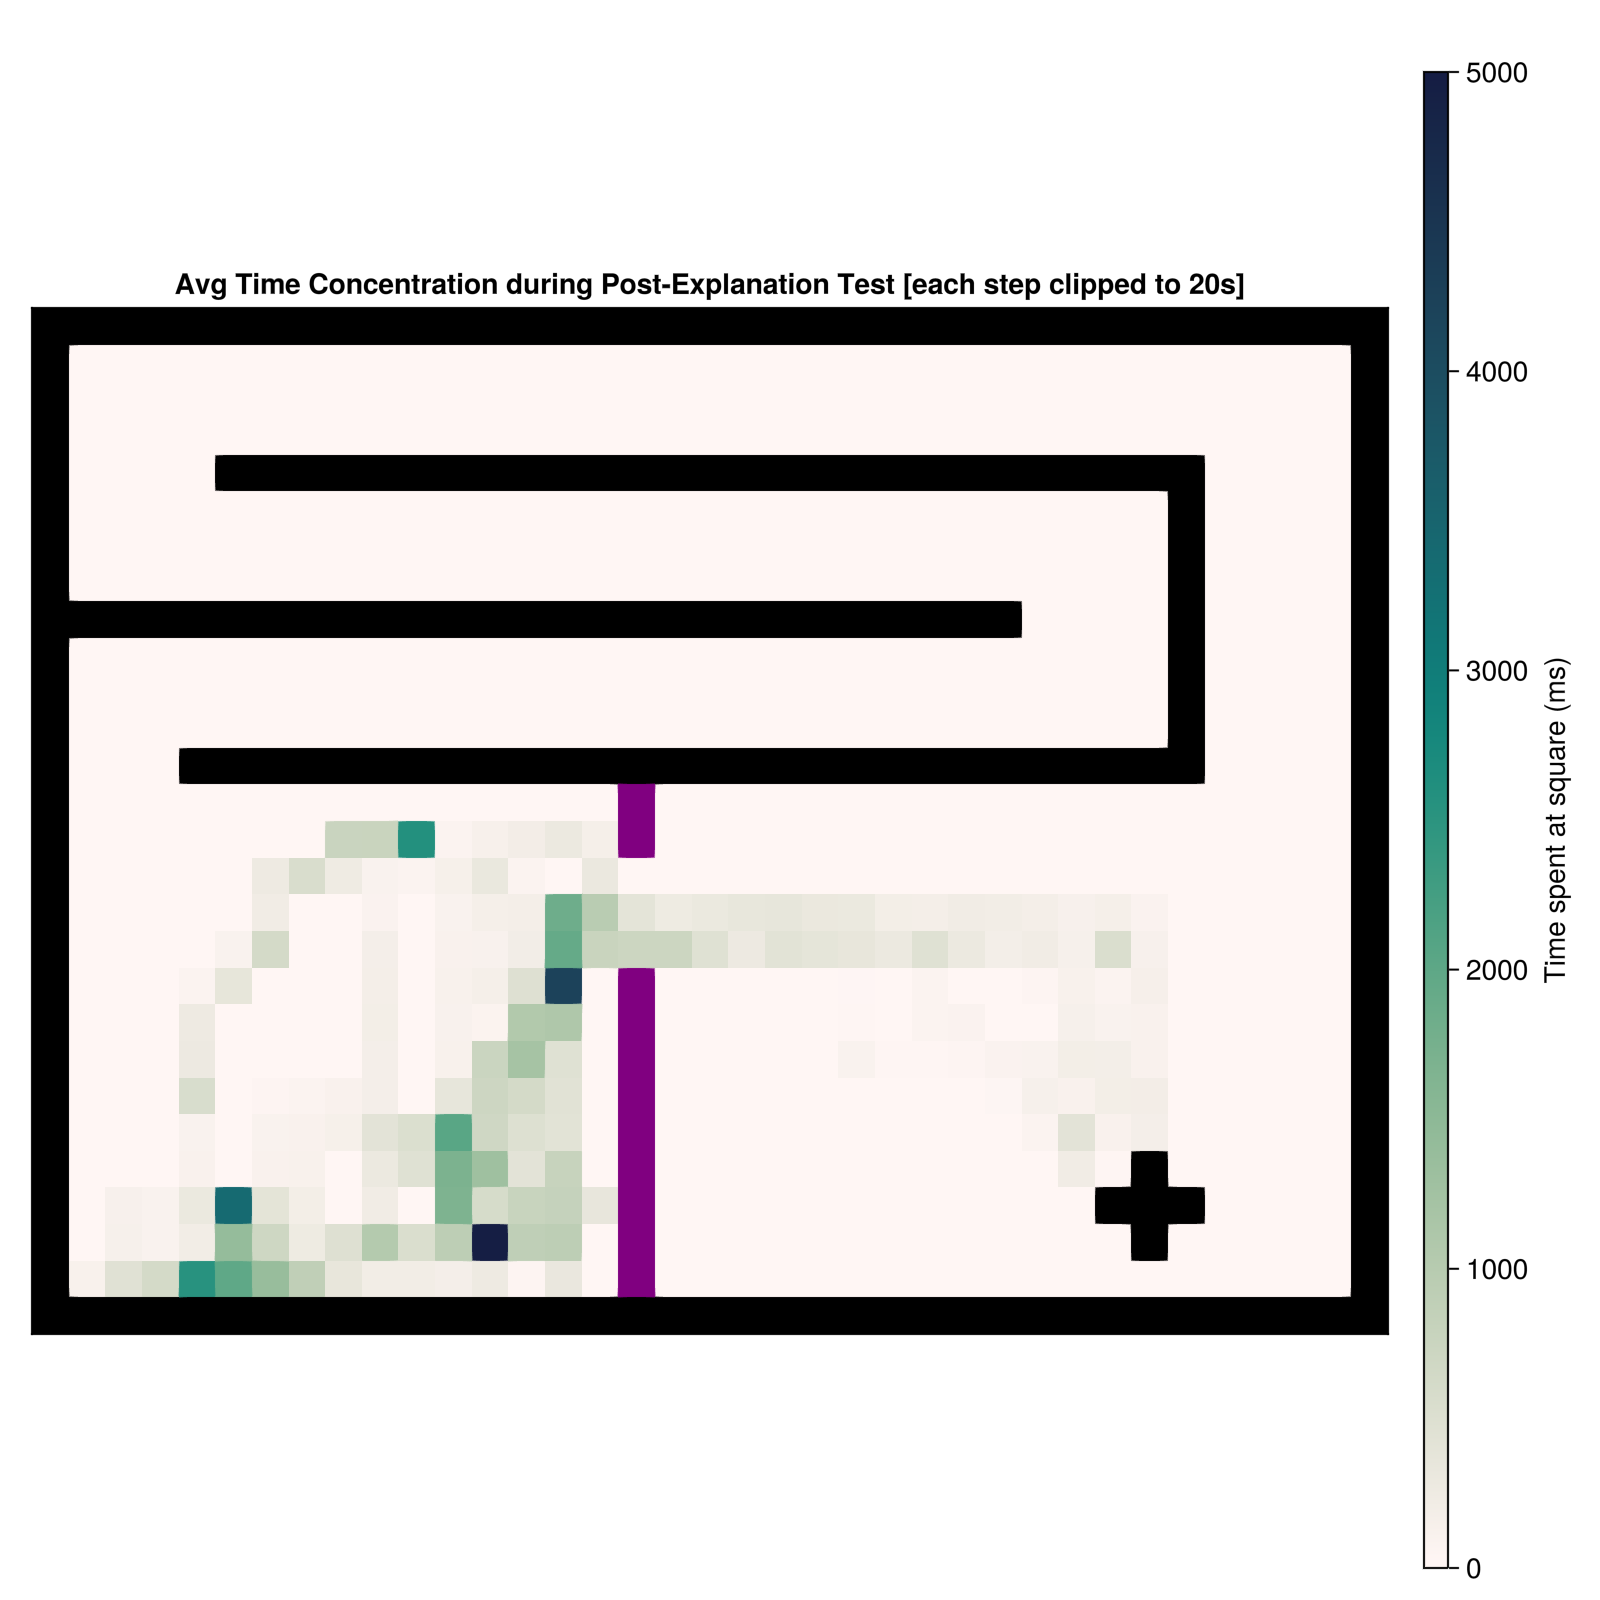

In [115]:
# multi-run heatmap

i = 4
tr = named_trace_lists["test2"][i][2]
t, _, t_to_params = get_args(tr)
params = t_to_params(t)

GridWorlds.Viz.time_heatmap(
    params.map,
    [[p for (p, t, h) in GenPOMDPs.state_sequence(tr)] for tr in map(x -> x[2], named_trace_lists["test2"])],
    [[t for (a, t) in GenPOMDPs.action_sequence(tr)] for tr in map(x -> x[2], named_trace_lists["test2"])],
    clip_ms=20_000,
    title="Avg Time Concentration during Post-Explanation Test [each step clipped to 20s]",
    do_avg=true,
    n_to_avg_over=length(Set(map(x -> x[1], named_trace_lists["test2"])))
)

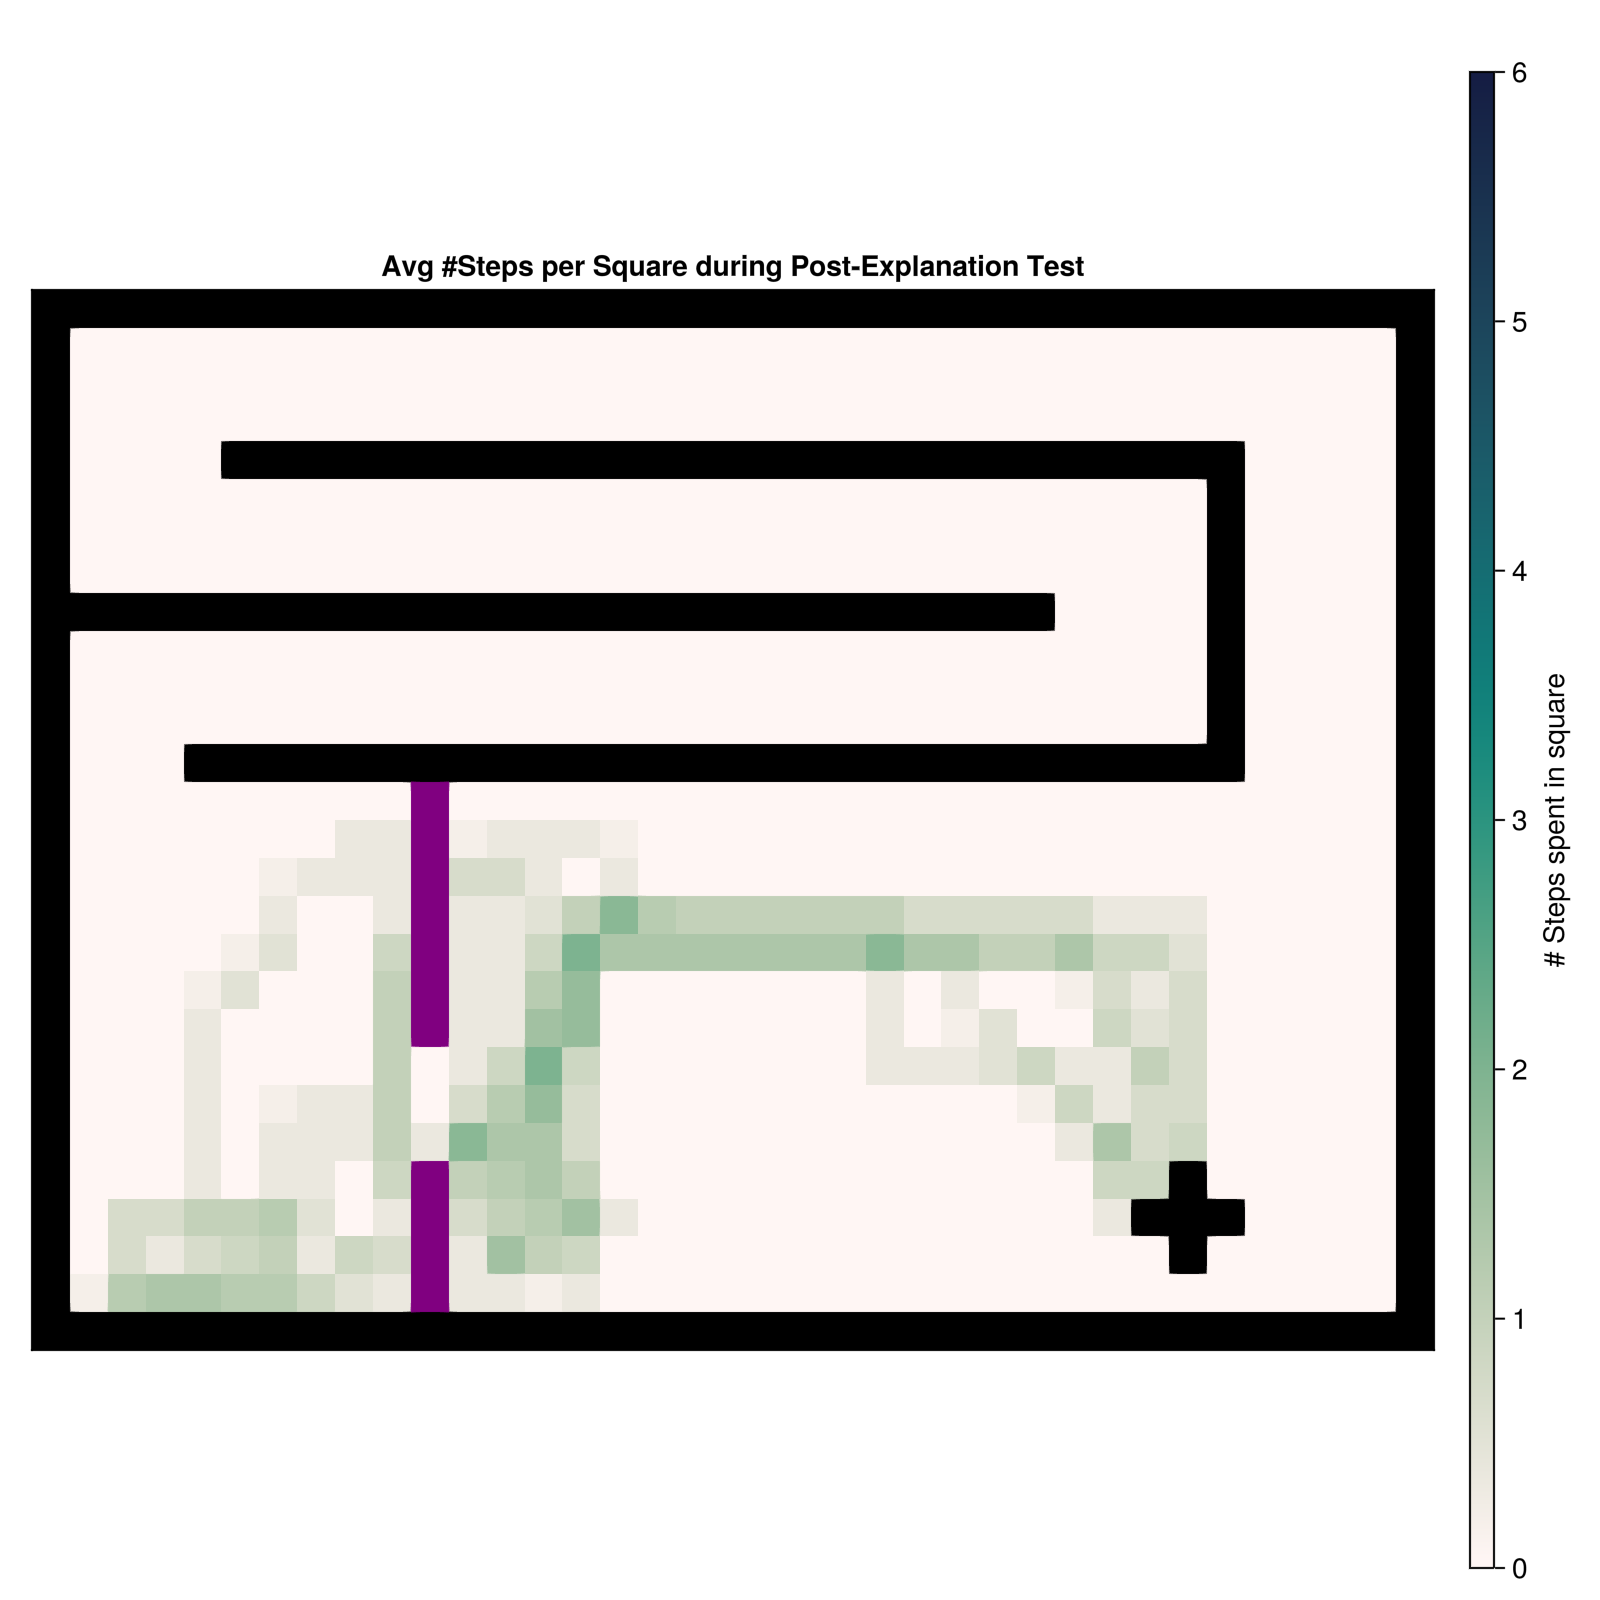

In [119]:
GridWorlds.Viz.time_heatmap(
    params.map,
    [[p for (p, t, h) in GenPOMDPs.state_sequence(tr)] for tr in map(x -> x[2], named_trace_lists["test2"])],
    [[t for (a, t) in GenPOMDPs.action_sequence(tr)] for tr in map(x -> x[2], named_trace_lists["test2"])],
    use_times=false,
    title="Avg #Steps per Square during Post-Explanation Test",
    do_avg=true,
    n_to_avg_over=length(Set(map(x -> x[1], named_trace_lists["test2"])))
)